In [1]:
import os
import random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image

import open_clip
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# pick which 
# model you want
model_name = "ViT-B-32"
pretrained = "openai"

# this returns (model, preprocess_transforms)
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

# freeze CLIP backbone
for param in model.parameters():
    param.requires_grad = False


/home/maker/.conda/envs/appliedAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maker/.conda/envs/appliedAI/lib/python3.10/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [2]:
# Paths
train_dir = Path("brain-tumor-dataset/Training")
test_dir = Path("brain-tumor-dataset/Testing")

# Dataset objects
train_ds = ImageFolder(train_dir, transform=preprocess)
test_ds = ImageFolder(test_dir, transform=preprocess)

# Optionally split training further into train/val
val_size = int(0.1 * len(train_ds))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

# Class names
classes = train_ds.dataset.classes  # from ImageFolder
print("Detected classes:", classes)

# Temporary loaders just for feature extraction
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)


Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
def extract_features(loader, model, device):
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats = model.encode_image(images)
            feats = feats.cpu()  # move to CPU to save memory
            all_features.append(feats)
            all_labels.append(labels)
    return torch.cat(all_features), torch.cat(all_labels)

print("Extracting train features...")
train_feats, train_labels = extract_features(train_loader, model, DEVICE)
print("Extracting val features...")
val_feats, val_labels = extract_features(val_loader, model, DEVICE)
print("Extracting test features...")
test_feats, test_labels = extract_features(test_loader, model, DEVICE)

# Wrap them in TensorDatasets for fast training
train_cached = TensorDataset(train_feats, train_labels)
val_cached = TensorDataset(val_feats, val_labels)
test_cached = TensorDataset(test_feats, test_labels)

train_loader = DataLoader(train_cached, batch_size=64, shuffle=True)
val_loader = DataLoader(val_cached, batch_size=64, shuffle=False)
test_loader = DataLoader(test_cached, batch_size=64, shuffle=False)

print("Feature caching complete!")


Extracting train features...
Extracting val features...
Extracting test features...
Feature caching complete!


In [4]:
feature_dim = train_feats.shape[1]

classifier = nn.Sequential(
    nn.Linear(feature_dim, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
).to(DEVICE)

optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 500 
accuracies = []
avg_losses = []
for epoch in range(num_epochs):
    classifier.train()
    losses = []

    for feats, labels in train_loader:
        feats, labels = feats.to(DEVICE), labels.to(DEVICE)
        logits = classifier(feats)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = np.mean(losses)
    avg_losses.append(avg_loss)

    # Validation
    classifier.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for feats, labels in val_loader:
            feats, labels = feats.to(DEVICE), labels.to(DEVICE)
            logits = classifier(feats)
            preds = logits.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    accuracies.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_loss:.4f} - Val acc: {acc:.4f}")


Epoch 1/500 - Train loss: 0.7481 - Val acc: 0.8144
Epoch 2/500 - Train loss: 0.4730 - Val acc: 0.8056
Epoch 3/500 - Train loss: 0.3870 - Val acc: 0.8669
Epoch 4/500 - Train loss: 0.3369 - Val acc: 0.8599
Epoch 5/500 - Train loss: 0.3062 - Val acc: 0.8879
Epoch 6/500 - Train loss: 0.2783 - Val acc: 0.8862
Epoch 7/500 - Train loss: 0.2607 - Val acc: 0.8827
Epoch 8/500 - Train loss: 0.2456 - Val acc: 0.8932
Epoch 9/500 - Train loss: 0.2354 - Val acc: 0.8984
Epoch 10/500 - Train loss: 0.2317 - Val acc: 0.8932
Epoch 11/500 - Train loss: 0.2218 - Val acc: 0.8914
Epoch 12/500 - Train loss: 0.2085 - Val acc: 0.8809
Epoch 13/500 - Train loss: 0.2061 - Val acc: 0.9002
Epoch 14/500 - Train loss: 0.1994 - Val acc: 0.9054
Epoch 15/500 - Train loss: 0.1933 - Val acc: 0.9072
Epoch 16/500 - Train loss: 0.1978 - Val acc: 0.8984
Epoch 17/500 - Train loss: 0.1894 - Val acc: 0.9072
Epoch 18/500 - Train loss: 0.1771 - Val acc: 0.9124
Epoch 19/500 - Train loss: 0.1795 - Val acc: 0.8984
Epoch 20/500 - Train 

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.85      0.92       300
  meningioma       0.85      0.96      0.90       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.97      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



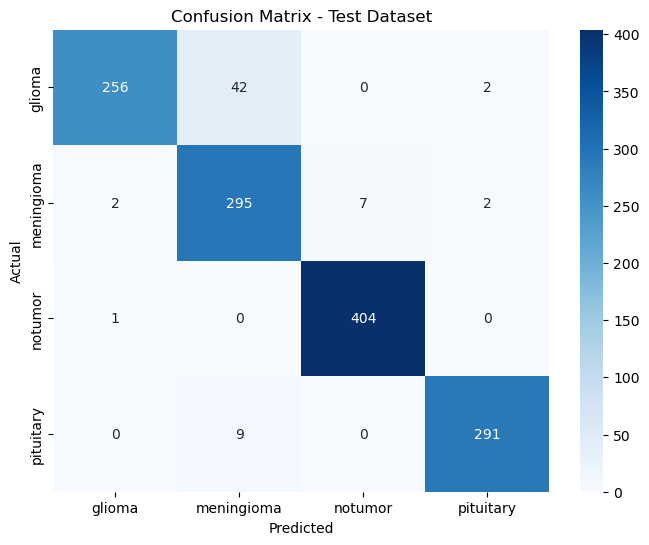

In [12]:
classifier.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for feats, labels in test_loader:
        feats, labels = feats.to(DEVICE), labels.to(DEVICE)
        logits = classifier(feats)
        preds = logits.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Dataset')
plt.show()


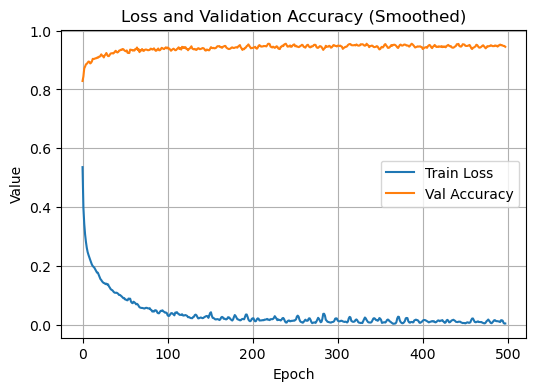

In [13]:
def smooth(data, window=3):
    """Simple moving average smoothing"""
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Smooth the curves
smoothed_losses = smooth(avg_losses, window=3)
smoothed_accs = smooth(accuracies, window=3)

plt.figure(figsize=(6,4))
plt.plot(smoothed_losses, label='Train Loss')
plt.plot(smoothed_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Loss and Validation Accuracy (Smoothed)')
plt.grid(True)
plt.show()